# Remove Shadows Using Optimal Transport

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrahnis/nb-vegetation/blob/main/Step-03-Veggie-Transport.ipynb)

In [1]:
# if the notebook is running in colab we'll get the data from github
HOST_IS_COLAB = 'google.colab' in str(get_ipython())

if HOST_IS_COLAB:
    # if using the regular Colab runtime install rasterio and others packages
    !pip install rasterio --quiet --exists-action i
    !pip install fiona --quiet --exists-action i
    !pip install shapely --quiet --exists-action i
    path = 'https://github.com/mrahnis/nb-vegetation/blob/main'
    params = '?raw=true'
    !mkdir results
else:
    path = '.'
    params = ''

In [2]:
import timeit
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import colormaps
from matplotlib.patches import Patch, Rectangle
import fiona
import shapely
import rasterio
from rasterio.windows import from_bounds
from rasterio.features import shapes
from skimage import segmentation, feature, future, morphology
from skimage.exposure import histogram, rescale_intensity
from skimage.filters import rank, apply_hysteresis_threshold
from skimage.color import rgb2lab, lab2rgb, rgb2hsv, hsv2rgb, rgb2ycbcr, ycbcr2rgb
from sklearn.ensemble import RandomForestClassifier

In [3]:
"""Load RGB+NIR TIFF data"""
image_file = '{}/data/pa_greatmarsh_2022_naip.tif{}'.format(path, params)
src = rasterio.open(image_file)

# read band data
rgb = src.read()

# switch from band-first raster to band-last image to display later
img = np.moveaxis(src.read(), 0, 2)

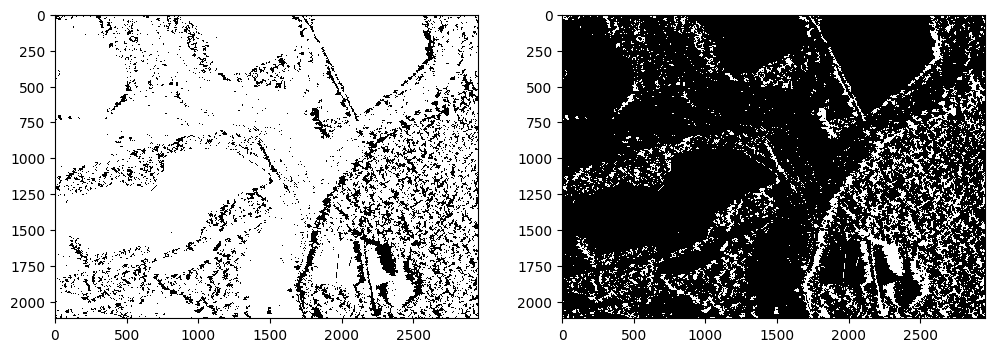

In [4]:
"""Load shadow mask to a boolean array"""
mask_file = '{}/results/dark_mask.tif{}'.format(path, params)
mask_src = rasterio.open(mask_file)
# shade = np.squeeze(mask_src.read()).astype(bool)

mask = np.where(mask_src.read() >= 0.4, 1, 0)
shade = np.squeeze(mask).astype(bool)

"""Load sunlit mask to a boolean array"""
# use all sunlit pixels - may get representative proportions of field and treetop, works well
sunlit = ~shade

# use sunlit mask pixels
# sunmask_file = '{}/results/sunlit_mask.tif{}'.format(path, params)
# sunmask_src = rasterio.open(sunmask_file)
# sunlit = np.squeeze(sunmask_src.read()).astype(bool)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
ax1.imshow(shade, cmap='gray_r', interpolation='none')
ax2.imshow(sunlit, cmap='gray_r', interpolation='none')

plt.show()

In [5]:
"""Create a band-first image in new working colorspace"""
cs = 'hsv'

if cs == 'lab':
    _band_cs = rgb2lab(rgb[:3,:,:], channel_axis=0)
    band_cs = np.append(_band_cs, rgb[[3],:,:], axis=0)
    channels = ['L*', 'a*', 'b*', 'NIR']
    channel_range=[[-40,40],[0,100]]
elif cs == 'ycbcr':
    _band_cs = rgb2ycbcr(rgb[:3,:,:], channel_axis=0)
    band_cs = np.append(_band_cs, rgb[[3],:,:], axis=0)
    channels = ['Y', 'Cb', 'Cr', 'NIR']
    channel_range=[[80,160],[40,160]]
else:
    _band_cs = rgb2hsv(rgb[:3,:,:], channel_axis=0)
    band_cs = np.append(_band_cs, rgb[[3],:,:]/255, axis=0)
    channels = ['H', 'S', 'V', 'NIR']
    channel_range=[[0,1],[0,1]]

What do the image histograms look like inside and outside the shadow mask? 

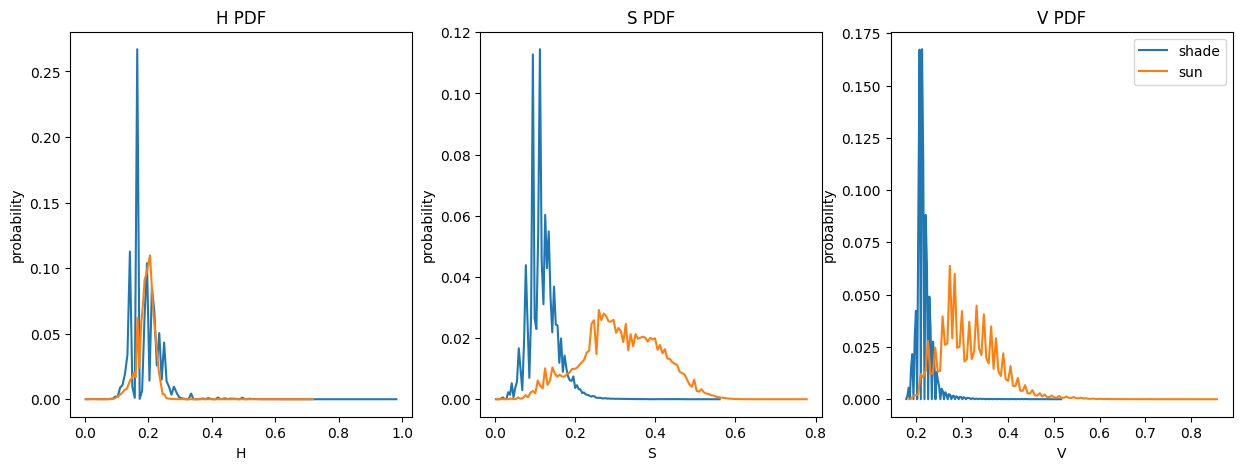

In [6]:
from scipy import stats

nbins = 128

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))

# shade nbins is smaller because few pixels and many bins yields unrealistic zero bins 
comp1_sunlit_hist, comp1_sunlit_centers = histogram(band_cs[0][~shade], nbins=nbins)
comp1_shade_hist, comp1_shade_centers = histogram(band_cs[0][shade], nbins=nbins)

ax0.plot(comp1_shade_centers, comp1_shade_hist/np.sum(comp1_shade_hist), label='shade')
ax0.plot(comp1_sunlit_centers, comp1_sunlit_hist/np.sum(comp1_sunlit_hist), label='sun')
ax0.set_title(f"{channels[0]} PDF")
ax0.set_xlabel(f'{channels[0]}')
ax0.set_ylabel('probability')

comp2_sunlit_hist, comp2_sunlit_centers = histogram(band_cs[1][~shade], nbins=nbins)
comp2_shade_hist, comp2_shade_centers = histogram(band_cs[1][shade], nbins=nbins)

ax1.plot(comp2_shade_centers, comp2_shade_hist/np.sum(comp2_shade_hist), label='shade')
ax1.plot(comp2_sunlit_centers, comp2_sunlit_hist/np.sum(comp2_sunlit_hist), label='sun')
ax1.set_title(f"{channels[1]} PDF")
ax1.set_xlabel(f'{channels[1]}')
ax1.set_ylabel('probability')

comp3_sunlit_hist, comp3_sunlit_centers = histogram(band_cs[2][~shade], nbins=nbins)
comp3_shade_hist, comp3_shade_centers = histogram(band_cs[2][shade], nbins=nbins)

ax2.plot(comp3_shade_centers, comp3_shade_hist/np.sum(comp3_shade_hist), label='shade')
ax2.plot(comp3_sunlit_centers, comp3_sunlit_hist/np.sum(comp3_sunlit_hist), label='sun')
ax2.set_title(f"{channels[2]} PDF")
ax2.set_xlabel(f'{channels[2]}')
ax2.set_ylabel('probability')

plt.legend()
plt.show()

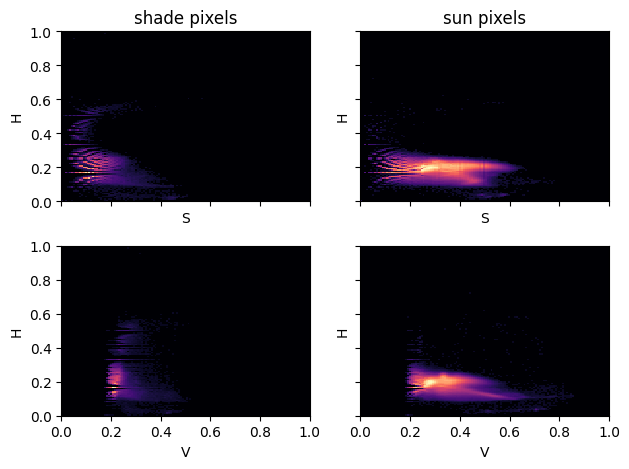

In [7]:
gamma = 0.25

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

ax0.hist2d(band_cs[1][shade], band_cs[0][shade], bins=nbins, norm=colors.PowerNorm(gamma), cmap='magma', range=channel_range)
ax0.set_xlabel(f'{channels[1]}')
ax0.set_ylabel(f'{channels[0]}')
ax0.set_title('shade pixels')

ax1.hist2d(band_cs[1][~shade], band_cs[0][~shade], bins=nbins, norm=colors.PowerNorm(gamma), cmap='magma', range=channel_range)
ax1.set_xlabel(f'{channels[1]}')
ax1.set_ylabel(f'{channels[0]}')
ax1.set_title('sun pixels')

ax2.hist2d(band_cs[2][shade], band_cs[0][shade], bins=nbins, norm=colors.PowerNorm(gamma), cmap='magma', range=channel_range)
ax2.set_xlabel(f'{channels[2]}')
ax2.set_ylabel(f'{channels[0]}')

ax3.hist2d(band_cs[2][~shade], band_cs[0][~shade], bins=nbins, norm=colors.PowerNorm(gamma), cmap='magma', range=channel_range)
ax3.set_xlabel(f'{channels[2]}')
ax3.set_ylabel(f'{channels[0]}')

plt.tight_layout()

## Shadow removal with optimal transport

Can we eliminate the shadows using optimal transport? This follows the example from the POT documentation:
[OT for image color adaptation with mapping estimation](https://pythonot.github.io/auto_examples/domain-adaptation/plot_otda_mapping_colors_images.html#sphx-glr-auto-examples-domain-adaptation-plot-otda-mapping-colors-images-py)

In [8]:
def im2mat(img):
    """Converts an image to matrix (one pixel per line)"""
    # return img.reshape(img.shape[1] * img.shape[2], img.shape[0]) 
    return img.reshape(img.shape[0] * img.shape[1], img.shape[2])


def mat2im(X, shape):
    """Converts back a matrix to an image"""
    return X.reshape(shape)


def minmax(img):
    return np.clip(img, 0, 1)

### Construct shade and sun matrices

In [9]:
img_cs = np.moveaxis(band_cs, 0, 2) # transform from band-first to band-last
X = im2mat(img_cs)                  # transform from image data to matrices

# test for agreement
print(f'Matrix {channels[0]}{channels[1]}{channels[2]} value ranges')
print(channels[0], ':', img_cs[:,:,0].min(), img_cs[:,:,0].max())
assert (img_cs[:,:,0].min() == X[:,0].min()) & (img_cs[:,:,0].max() == X[:,0].max())
print(channels[1], ':', img_cs[:,:,1].min(), img_cs[:,:,1].max())
assert (img_cs[:,:,1].min() == X[:,1].min()) & (img_cs[:,:,1].max() == X[:,1].max())
print(channels[2], ':', img_cs[:,:,2].min(), img_cs[:,:,2].max())
assert (img_cs[:,:,2].min() == X[:,2].min()) & (img_cs[:,:,2].max() == X[:,2].max())

shade_flat_mask = shade.flatten()
sunlit_flat_mask = sunlit.flatten()

X1 = X[shade_flat_mask, :]   # the shade pixels
X2 = X[sunlit_flat_mask, :]  # the sun pixels
print("shade pixels shape", X1.shape)
print("sun pixels shape", X2.shape)

Matrix HSV value ranges
H : 0.0 0.9861111111111112
S : 0.0 0.7810650887573963
V : 0.1764705882352941 0.8588235294117647
shade pixels shape (813080, 4)
sun pixels shape (5432070, 4)


### Make source and target training samples

In [10]:
# training samples
nb = 2000
rng = np.random.RandomState(42)

idx1 = rng.randint(X1.shape[0], size=(nb,))
idx2 = rng.randint(X2.shape[0], size=(nb,))

# Xs is the source, Xt is the target; we want to transport the shaded areas to the sunlit areas
Xs = X1[idx1, :] # the shade sample
Xt = X2[idx2, :] # the sun sample

### Visualize the training samples

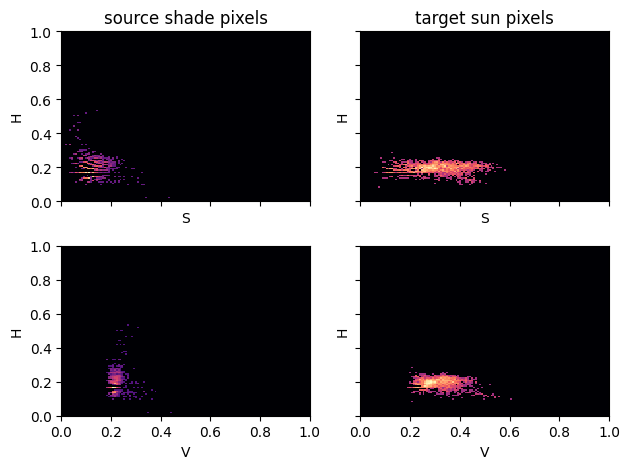

In [11]:
gamma = 0.25

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

# not going to color the samples here
ax0.hist2d(Xs[:, 1], Xs[:, 0], bins=nbins, norm=colors.PowerNorm(gamma), cmap='magma', range=channel_range)
ax0.set_xlabel(f'{channels[1]}')
ax0.set_ylabel(f'{channels[0]}')
ax0.set_title('source shade pixels')

ax1.hist2d(Xt[:, 1], Xt[:, 0], bins=nbins, norm=colors.PowerNorm(gamma), cmap='magma', range=channel_range)
ax1.set_xlabel(f'{channels[1]}')
ax1.set_ylabel(f'{channels[0]}')
ax1.set_title('target sun pixels')

ax2.hist2d(Xs[:, 2], Xs[:, 0], bins=nbins, norm=colors.PowerNorm(gamma), cmap='magma', range=channel_range)
ax2.set_xlabel(f'{channels[2]}')
ax2.set_ylabel(f'{channels[0]}')
# ax2.set_title('shade sample pixels')

ax3.hist2d(Xt[:, 2], Xt[:, 0], bins=nbins, norm=colors.PowerNorm(gamma), cmap='magma', range=channel_range)
ax3.set_xlabel(f'{channels[2]}')
ax3.set_ylabel(f'{channels[0]}')
# ax3.set_title('sun sample pixels')

plt.tight_layout()

### Transform the shade pixels using optimal transport

Shadows tend toward blue as opposed to the sunlit parts...
In HSV colorspace:

- 1/3 or 120 degrees is green,
- 1/2 or 180 degrees is cyan,
- 2/3 or 270 degrees is blue

In [12]:
'''
Each OT model has three basic steps:
- initialize an optimal transport model
- fit a source data, Xs, to a target data, Xt
- transform a source data
'''
import ot

model = 'linear'
fit_dims = [0,1,2,3]

start_time = timeit.default_timer()

if model == 'linear':
    # LINEAR MAPPING TRANSPORT (reasonable results, but X1_transformed * 0.9 provides better match)
    ot_mapping_linear = ot.da.MappingTransport(
        mu=1e0, eta=1e-8, bias=True, max_iter=20, verbose=True)
    # ot_mapping_linear = ot.da.MappingTransport(
    #     mu=1e0, eta=1e-4, sigma=1, bias=False, max_iter=50, verbose=True)
    ot_mapping_linear.fit(Xs=Xs[:,fit_dims], Xt=Xt[:,fit_dims])            # fit Xs (shade sample) to Xt (sun sample)
    X1_transformed_dims = ot_mapping_linear.transform(Xs=X1[:,fit_dims])   # transform the full image matrix
elif model == 'emd':
    # EMD TRANSPORT (reasonable results)
    ot_emd = ot.da.EMDTransport(max_iter=200000)
    ot_emd.fit(Xs=Xs[:,fit_dims], Xt=Xt[:,fit_dims])
    X1_transformed_dims = ot_emd.transform(Xs=X1[:,fit_dims])
elif model == 'emd-laplace':
    # EMD TRANSPORT WITH LAPLACIAN REGULARIZATION
    ot_emd = ot.da.EMDLaplaceTransport(reg_type='pos', similarity='gauss', max_iter=200000)
    ot_emd.fit(Xs=Xs[:,fit_dims], Xt=Xt[:,fit_dims])
    X1_transformed_dims = ot_emd.transform(Xs=X1[:,fit_dims])
elif model == 'sinkhorn':
    # SINKHORN TRANSPORT (produces too uniform a result)
    ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
    ot_sinkhorn.fit(Xs=Xs[:,fit_dims], Xt=Xt[:,fit_dims])
    X1_transformed_dims = ot_sinkhorn.transform(Xs=X1[:,fit_dims])
else:
    print('need an optimal transport model')
    
# update the X matrix with X1_transformed inserted at flat_mask coordinates
#X1_transformed = X1.copy()
#X1_transformed[:,fit_dims:] = X1_transformed_dims
X1_transformed = X1_transformed_dims

elapsed = timeit.default_timer() - start_time
print(f'Elapsed time: {elapsed}')
print('')
print(f'Source-Transformed {channels[0]}{channels[1]}{channels[2]} value ranges:')
print(X1_transformed[:, 0].min(), X1_transformed[:, 0].max())
print(X1_transformed[:, 1].min(), X1_transformed[:, 1].max())
print(X1_transformed[:, 2].min(), X1_transformed[:, 2].max())

It.  |Loss        |Delta loss
--------------------------------
    0|3.172651e+02|0.000000e+00
    1|3.148386e+02|-7.647961e-03
    2|3.146935e+02|-4.608368e-04
    3|3.146240e+02|-2.209344e-04
    4|3.145836e+02|-1.285551e-04
    5|3.145582e+02|-8.049020e-05
    6|3.145408e+02|-5.536261e-05
    7|3.145283e+02|-3.995592e-05
    8|3.145190e+02|-2.938843e-05
    9|3.145118e+02|-2.307866e-05
   10|3.145060e+02|-1.823051e-05
   11|3.145014e+02|-1.479455e-05
   12|3.144975e+02|-1.230652e-05
   13|3.144948e+02|-8.501046e-06
Elapsed time: 365.602145700017

Source-Transformed HSV value ranges:
0.06600872054011304 0.5070160870987888
-0.07476464228255451 1.1996762327940704
0.14288534632472535 0.9009706985985232


EMD with HSV
- 2000 samples ~5 minutes
- 4000 samples ~10 minutes
- 8000 samples ~30 minutes with best fit to target

EMD Laplace with HSV, reg_type='pos'
- 1000 samples ~58 seconds (promising)
- 2000 samples ~4.5 minutes (pretty good!)

EMD Laplace with HSV, reg_type='disp', similarity='gauss' (gauss really bumps up time and lightens but doesn't eliminate shadows)
- 2000 samples ~70 minutes

Linear with L\*a\*b\* 
- 4000 samples ~3.5 minutes
- 8000 samples ~16 minutes

### Compare the transformed data to the target sample

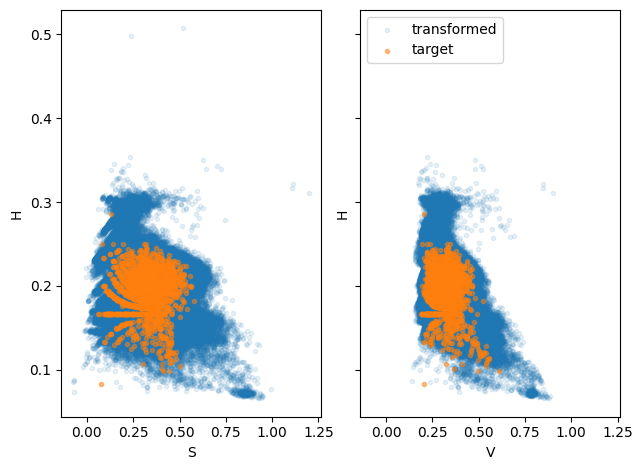

In [13]:
# compare the transformed data to the target sample
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

ax0.scatter(X1_transformed[:, 1], X1_transformed[:, 0], marker='.', alpha=0.1, label='transformed')
ax0.scatter(Xt[:, 1], Xt[:, 0], marker='.', alpha=0.5, label='target')
ax0.set_xlabel(f'{channels[1]}')
ax0.set_ylabel(f'{channels[0]}')

ax1.scatter(X1_transformed[:, 2], X1_transformed[:, 0], marker='.', alpha=0.1, label='transformed')
ax1.scatter(Xt[:, 2], Xt[:, 0], marker='.', alpha=0.5, label='target')
ax1.set_xlabel(f'{channels[2]}')
ax1.set_ylabel(f'{channels[0]}')

plt.legend(loc='upper left')
plt.tight_layout()

### Update the image with the transformed pixels

In [14]:
# the row indices to replace
ix = np.argwhere(shade_flat_mask).flatten()

# update the X matrix with X1_transformed inserted at flat_mask coordinates
X[ix, :] = X1_transformed

# reshape the updated L*a*b* matrix, X, back to an image
img_transformed = mat2im(X[:,:3], img[:,:,:3].shape)
img_transformed = mat2im(X, img.shape)

# print the value ranges...does it look reasonable???
print(f'Image Including Transformed {channels[0]}{channels[1]}{channels[2]} value ranges')
print(img_transformed[:, :, 0].min(), img_transformed[:, :, 0].max())
print(img_transformed[:, :, 1].min(), img_transformed[:, :, 1].max())
print(img_transformed[:, :, 2].min(), img_transformed[:, :, 2].max())

# double-check!
if cs == 'lab':
    assert (img_transformed[:, :, 0].min() >= 0) & (img_transformed[:, :, 0].max() <= 100)
    assert (img_transformed[:, :, 1].min() >= -128) & (img_transformed[:, :, 1].max() <= 127)
    assert (img_transformed[:, :, 2].min() >=-128) & (img_transformed[:, :, 2].max() <= 127)
elif cs=='ycbcr':
    pass
elif cs == 'hsv':
    img_transformed = np.clip(img_transformed, 0, 1)
    assert (img_transformed[:, :, 0].min() >= 0) & (img_transformed[:, :, 0].max() <= 1)
    assert (img_transformed[:, :, 1].min() >= 0) & (img_transformed[:, :, 1].max() <= 1)
    assert (img_transformed[:, :, 2].min() >=0) & (img_transformed[:, :, 2].max() <= 1)
else:
    print('need a colorspace')

Image Including Transformed HSV value ranges
0.0 0.722222222222222
-0.07476464228255451 1.1996762327940704
0.14288534632472535 0.9009706985985232


### Convert the updated image from the working colorspace back to RGB 

In [15]:
# convert the updated colorspace image to rgb
if cs == 'lab':
    rgb_transformed_flt = lab2rgb(img_transformed[:,:,:3])
elif cs == 'ycbcr':
    rgb_transformed_flt = ycbcr2rgb(img_transformed[:,:,:3])
elif cs == 'hsv':
    rgb_transformed_flt = hsv2rgb(img_transformed[:,:,:3])
else:
    print('need to specify a colorspace')

# the result in band-last format for display
rgb_transformed = (np.rint(rgb_transformed_flt*255)).astype(np.uint8)

## Display the result

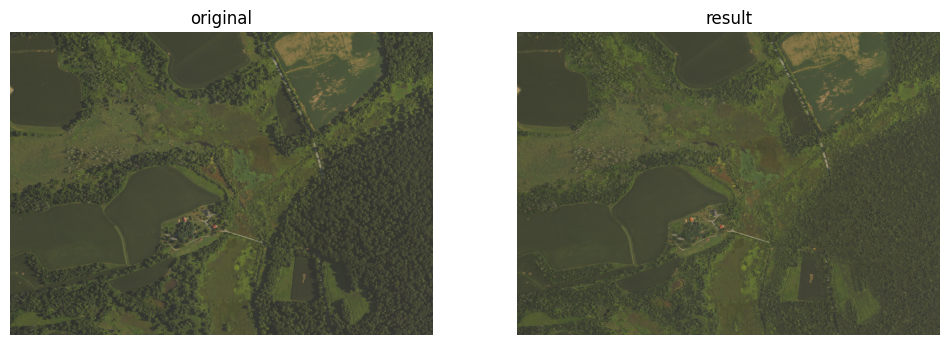

In [16]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax0.imshow(img[:,:,:3])
ax0.axis('off')
ax0.set_title('original')

ax1.imshow(rgb_transformed)
ax1.axis('off')
ax1.set_title('result')

plt.show()

## Write out the results

Running this cell will write out two files to the results directory.

In [17]:
out_raster = './results/shadow_corrected.tif'

# the band-first data for writing
rgb_transformed_bands = np.moveaxis(rgb_transformed, 2, 0)

# put the transformed nir band back
# nir_transformed = (np.rint(img_transformed[:,:,[3]]*255)).astype(np.uint8)
# rgb_transformed_bands = np.append(band_cs_, rgb[[3],:,:], axis=0)

""" Write out the classification result in raster format """
with rasterio.open(
    out_raster,
    'w',
    driver='GTiff',
    height=rgb_transformed_bands.shape[1],
    width=rgb_transformed_bands.shape[2],
    count=rgb_transformed_bands.shape[0],
    dtype=rgb_transformed_bands.dtype,
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(rgb_transformed_bands)
    
src.close()


# How does this compare with eyeballing?

Visually estimate a translating and scaling required to match the distributions.

In [18]:
# compare with eyeballing it, multiplying and translating in HSV space
from skimage.exposure import rescale_intensity

X1_transformed = np.stack((
    (X1[:,0]-0.1)*0.8+0.1,
    X1[:,1]*2.2+0.05,
    X1[:,2]+(X1[:,2]-X1[:,2].min())*1.8,
    X1[:,3]),
    axis = 1)

# update the X matrix with X1_transformed inserted at flat_mask coordinates
X[ix, :] = X1_transformed

# reshape the updated L*a*b* matrix, X, back to an image
img_transformed = mat2im(X[:,:3], img[:,:,:3].shape)
img_transformed = mat2im(X, img.shape)

img_transformed = np.clip(img_transformed, 0, 1)

# convert the lab image to rgb
rgb_transformed_flt = hsv2rgb(img_transformed[:,:,:3])

rgb_transformed = (np.rint(rgb_transformed_flt*255)).astype(np.uint8)
rgb_transformed_bands = np.moveaxis(rgb_transformed, 2, 0)

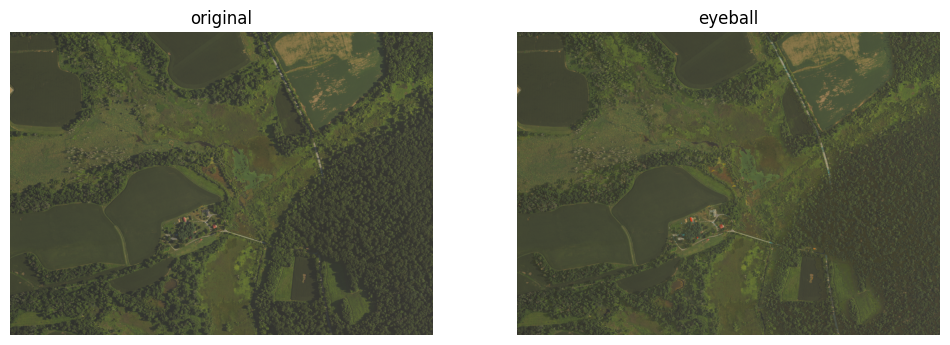

In [19]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax0.imshow(img[:,:,:3])
ax0.axis('off')
ax0.set_title('original')

ax1.imshow(rgb_transformed)
ax1.axis('off')
ax1.set_title('eyeball')

plt.show()

In [20]:
out_raster = './results/shadow_scaled.tif'

""" Write out the scaled shadow raster """
with rasterio.open(
    out_raster,
    'w',
    driver='GTiff',
    height=rgb_transformed_bands.shape[1],
    width=rgb_transformed_bands.shape[2],
    count=rgb_transformed_bands.shape[0],
    dtype=rgb_transformed_bands.dtype,
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(rgb_transformed_bands)
